# Insertion algorithm 

In [23]:
%matplotlib inline

import torch
import numpy as np
import signatory
import math

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from insertion import Insertion, get_A_matrix, solve_optimization_problem
from tools import get_signature_as_tensor


In [24]:
test_tensor = torch.rand((3,3,3))
print(test_tensor[0,1,2])

tensor(0.5661)


## Insertion operator 

In [25]:
test_path = torch.rand((1,10,5))
signature_test = signatory.signature(test_path, 2)
get_signature_as_tensor(signature_test,5,2)

{'Depth 1': tensor([-0.0839,  0.4946,  0.4240,  0.1121, -0.2925]),
 'Depth 2': tensor([[ 0.0035, -0.0484,  0.0622,  0.0428,  0.1848],
         [ 0.0069,  0.1223,  0.3189, -0.0345, -0.1270],
         [-0.0978, -0.1092,  0.0899,  0.1236, -0.2445],
         [-0.0522,  0.0899, -0.0761,  0.0063, -0.1003],
         [-0.1603, -0.0177,  0.1205,  0.0675,  0.0428]])}

In [26]:
x=[1,2,3,4,5]

p=3

n=2

dimension=5

Insertion(p,n,x,signature_test,dimension)

tensor([[[ 0.0070,  0.0141,  0.0211,  0.0282,  0.0352],
         [-0.0969, -0.1937, -0.2906, -0.3875, -0.4844],
         [ 0.1243,  0.2487,  0.3730,  0.4974,  0.6217],
         [ 0.0856,  0.1712,  0.2568,  0.3425,  0.4281],
         [ 0.3697,  0.7394,  1.1090,  1.4787,  1.8484]],

        [[ 0.0139,  0.0277,  0.0416,  0.0555,  0.0694],
         [ 0.2447,  0.4893,  0.7340,  0.9787,  1.2234],
         [ 0.6379,  1.2758,  1.9136,  2.5515,  3.1894],
         [-0.0689, -0.1379, -0.2068, -0.2757, -0.3447],
         [-0.2540, -0.5080, -0.7619, -1.0159, -1.2699]],

        [[-0.1955, -0.3910, -0.5865, -0.7820, -0.9775],
         [-0.2184, -0.4368, -0.6552, -0.8735, -1.0919],
         [ 0.1798,  0.3596,  0.5394,  0.7192,  0.8990],
         [ 0.2473,  0.4946,  0.7418,  0.9891,  1.2364],
         [-0.4891, -0.9782, -1.4673, -1.9564, -2.4455]],

        [[-0.1044, -0.2088, -0.3133, -0.4177, -0.5221],
         [ 0.1798,  0.3596,  0.5395,  0.7193,  0.8991],
         [-0.1522, -0.3044, -0.4566, -0.60

In [27]:
dimension=4
test_path = torch.rand((1,10,dimension))
n=3
signature_test = signatory.signature(test_path, n)
last_signature_term = get_signature_as_tensor(signature_test,dimension,n)["Depth "+ str(n)]
p=3

# Test if A has the right structure: A^TA should be diagonal with same values in the diagonal.
A_matrix=get_A_matrix(p,signature_test,n,dimension)
print(np.matmul(np.transpose(A_matrix),A_matrix))

[[23.52959059  0.          0.          0.        ]
 [ 0.         23.52959059  0.          0.        ]
 [ 0.          0.         23.52959059  0.        ]
 [ 0.          0.          0.         23.52959059]]


In [28]:
signature = signatory.signature(test_path, 2)
signature_next = signatory.signature(test_path,3)

solve_optimization_problem(signature, signature_next,p=2,n=2,dimension=2)

array([ 0.15781454, -0.98746877])

## Tests

### Tests on semi-circle 

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


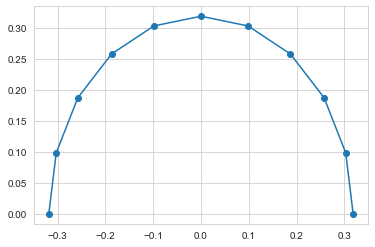

In [29]:
points = np.arange(0,1.1,0.1)

print(points)

x1 = 1/(math.pi)*np.cos(math.pi*points)

x2 = 1/(math.pi)*np.sin(math.pi*points)

sns.set_style('whitegrid')

plt.plot(x1,x2,linestyle='-',marker='o')
plt.show()

torch.Size([1, 62])


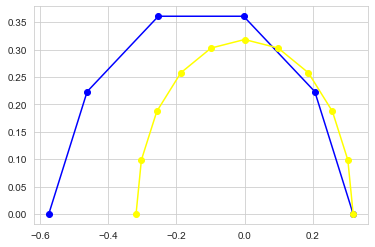

In [30]:
path = torch.tensor(np.array((x1,x2)).T)

k=4

signature = signatory.signature(path.unsqueeze(0), k)
signature_next = signatory.signature(path.unsqueeze(0), k+1)
print(signature_next.shape)

reconstructed_path_derivatives = np.zeros(shape=(2,k+1))

reconstructed_path = np.zeros(shape=(2,k+2))
reconstructed_path[:,0]=[x1[0],x2[0]]

for p in np.arange(1,k+2):

    x_optimal = solve_optimization_problem(signature, signature_next,p,n=k,dimension=2)
    
    reconstructed_path_derivatives[:,p-1] = x_optimal 
    
    reconstructed_path[:,p] = reconstructed_path[:,p-1] + reconstructed_path_derivatives[:,p-1]*(1/k)
    
plt.plot(reconstructed_path[0,:],reconstructed_path[1,:],c='blue',marker='o')
plt.plot(x1,x2,linestyle='-',marker='o',c='yellow')
plt.show()
    